The following notebook presents a CFD study of the flow simulation over a semicircular obstacle in the channel using Watertight meshing and Fluent solver -- using Python scripting in ANSYS PyFluent 

**Importing the required files**

In [84]:
import ansys.fluent.core as pyfluent
from matplotlib import pyplot as plt
from matplotlib import image
%matplotlib inline

**Starting the meshing session**

In [85]:
# Open a meshing session------------------------------
meshing_session = pyfluent.launch_fluent(precision = "double", processor_count = 4, mode = "meshing", show_gui = True)
workflow = meshing_session.workflow
meshing = meshing_session.meshing

Setting the Watertight meshing workflow

In [86]:
# The meshing workflow is selected as the "Watertight Meshing Workflow"
workflow.InitializeWorkflow(WorkflowType = r'Watertight Geometry')
# The global scale setting
meshing.GlobalSettings.LengthUnit.set_state(r'mm')
meshing.GlobalSettings.AreaUnit.set_state(r'mm^2')
meshing.GlobalSettings.VolumeUnit.set_state(r'mm^3')

Importing geometry

In [87]:
workflow.TaskObject['Import Geometry'].Arguments.set_state({r'FileName': r'inverse_u.scdoc',})
workflow.TaskObject['Import Geometry'].Execute()

True

Local sizing - adding the BOIs in the geometry

In [88]:
#local sizing- setting up Body of Infulence for refining the mesh  ------------------------------------------
# 1st BOI
workflow.TaskObject['Add Local Sizing'].Arguments.set_state({r'AddChild': r'yes',r'BOIExecution': r'Body Of Influence',r'BOIFaceLabelList': \
                                                             [r'boi_circular-solid'],r'BOISize': 2,})
workflow.TaskObject['Add Local Sizing'].AddChildAndUpdate()   # executing the BOI - 1
# 2nd BOI
workflow.TaskObject['Add Local Sizing'].Arguments.set_state({r'AddChild': r'yes',r'BOIExecution': r'Body Of Influence',r'BOIFaceLabelList': \
                                                             [r'boi_rectangle-solid'],r'BOISize': 4,})
workflow.TaskObject['Add Local Sizing'].AddChildAndUpdate()  # executing the BOI - 2

True

The surface meshing

In [89]:
# -------Surface mesh --- Cells per gap, Curvature Normal angle, max size, min size ---------------------------------------
workflow.TaskObject['Generate the Surface Mesh'].Arguments.set_state({r'CFDSurfaceMeshControls': {r'CellsPerGap': 5,r'CurvatureNormalAngle': \
                                                                                                  10,r'MaxSize': 10,r'MinSize': 5,}\
                                                                      ,r'SeparationRequired': r'Yes',})
workflow.TaskObject['Generate the Surface Mesh'].Execute()   # executing the surface mesh

True

Describe geometry task

In [90]:
workflow.TaskObject['Describe Geometry'].UpdateChildTasks(SetupTypeChanged=False)
workflow.TaskObject['Describe Geometry'].Arguments.set_state({r'SetupType': r'The geometry consists of only fluid regions with no voids',})
workflow.TaskObject['Describe Geometry'].UpdateChildTasks(SetupTypeChanged=True)
workflow.TaskObject['Describe Geometry'].Execute()

True

Update boundaries

In [91]:
workflow.TaskObject['Update Boundaries'].Execute()
workflow.TaskObject['Update Regions'].Execute()

True

Add Boundary layers

In [92]:
workflow.TaskObject['Add Boundary Layers'].Arguments.set_state({r'LocalPrismPreferences': {r'Continuous': r'Stair Step',},r'NumberOfLayers': 5,})
workflow.TaskObject['Add Boundary Layers'].AddChildAndUpdate()

True

Generate the volume mesh

In [93]:
workflow.TaskObject['Generate the Volume Mesh'].Arguments.set_state({r'VolumeFill': r'poly-hexcore',})
workflow.TaskObject['Generate the Volume Mesh'].Execute()

True

**Switching to solver mode**

In [94]:
solver = meshing_session.switch_to_solver()

changing the scale of geometry and check the mesh

In [95]:
solver.tui.define.units("length","mm")
solver.mesh.check()

'*the-non-printing-object*'

Viscous model selection

In [96]:
solver.setup.models.viscous()

{'model': 'k-omega',
 'options': {'curvature_correction': False,
  'corner_flow_correction': False,
  'production_kato_launder': False},
 'k_omega_model': 'sst',
 'k_omega_options': {'kw_low_re_correction': False},
 'transition_module': 'none',
 'turbulence_expert': {'kato_launder_model': False,
  'production_limiter': {'enable_prod_limiter': True, 'clip_factor': 10.0},
  'turb_non_newtonian': False,
  'restore_sst_v61': False},
 'user_defined': {'turb_visc_func': 'none'}}

SST k-omega model is already seleted, so no need to change it

Assinging the material in the fluid domain

In [97]:
solver.setup.materials()

{'database': {'database_type': 'fluent-database'},
 'fluid': {'air': {'density': {'option': 'constant', 'value': 1.225},
   'viscosity': {'option': 'constant', 'value': 1.7894e-05},
   'specific_heat': {'option': 'constant', 'value': 1006.43},
   'thermal_conductivity': {'option': 'constant', 'value': 0.0242},
   'molecular_weight': {'option': 'constant', 'value': 28.966},
   'therm_exp_coeff': {'option': 'constant', 'value': 0},
   'speed_of_sound': {'option': 'none'}}},
 'solid': {'aluminum': {'density': {'option': 'constant', 'value': 2719},
   'specific_heat': {'option': 'constant', 'value': 871},
   'thermal_conductivity': {'option': 'constant', 'value': 202.4}}}}

since air is pre-selected, change it to "Water"

In [98]:
solver.setup.materials.database.copy_by_name(type = 'fluid', name = 'water-liquid')
solver.setup.materials.list_materials()

'*the-non-printing-object*'

water has been imported to the fluid list, this can be now assigned to the fluid

In [99]:
solver.setup.cell_zone_conditions.fluid['solid'].material = 'water-liquid'
solver.setup.cell_zone_conditions.fluid()

{'solid': {'material': 'water-liquid',
  'sources': False,
  'fixed': False,
  'mrf_motion': False,
  'reference_frame_axis_origin': [{'option': 'value', 'value': 0.0},
   {'option': 'value', 'value': 0.0},
   {'option': 'value', 'value': 0.0}],
  'reference_frame_axis_direction': [{'option': 'value', 'value': 0},
   {'option': 'value', 'value': 0},
   {'option': 'value', 'value': 1}],
  'laminar': False,
  'porous': False,
  'fanzone': False}}

Setting the boundary conditions

In [100]:
# setting the velocity magnitude as 10 m/s
solver.setup.boundary_conditions.velocity_inlet['inlet'].vmag = 10
# check, if the velocity magnitude has been changed
solver.setup.boundary_conditions.velocity_inlet()

{'inlet': {'velocity_spec': 'Magnitude, Normal to Boundary',
  'frame_of_reference': 'Absolute',
  'vmag': {'option': 'value', 'value': 10},
  'initial_gauge_pressure': {'option': 'value', 'value': 0},
  'ke_spec': 'Intensity and Viscosity Ratio',
  'turb_intensity': 0.05,
  'turb_viscosity_ratio': 10}}

Initialize the solution - 'Hybrid Initialization'

In [101]:
solver.solution.initialization.hybrid_initialize()

setting the no of iterations and run calculation

In [102]:
solver.solution.run_calculation.iter_count = 400
solver.solution.run_calculation.iterate()

Save the case and data file to the folder

In [103]:
solver.file.write(file_type = 'case-data', file_name = "inverse_u.cas.h5")

'*cx-overwrite-prompt?*'

**Post-processing**

Creating the pressure, velocity and turbulence kinetic energy contour

In [104]:
# creating the contour
solver.results.graphics.contour.create("velocity_contour")
# filling in the detail which variable to plot
solver.results.graphics.contour["velocity_contour"](field = "velocity-magnitude", surfaces_list = ["symmetry_left"])
# displaying it in the console
solver.results.graphics.contour["velocity_contour"].display()
# scaling it in screen, so that the image can be saved
solver.results.graphics.views.auto_scale()
# saving the picture
solver.results.graphics.picture.save_picture(file_name = "velocity")

'*cx-overwrite-prompt?*'

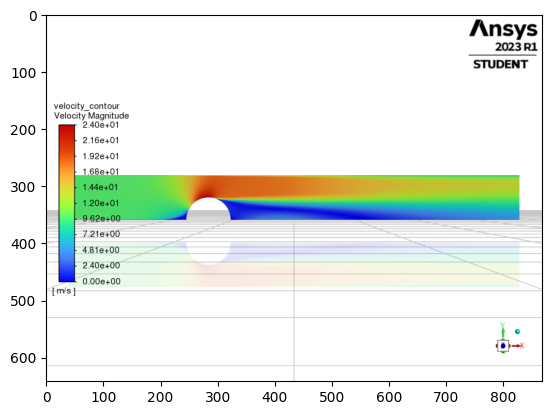

In [105]:
plt.imshow(image.imread("velocity.png"))

In [106]:
solver.results.graphics.contour.create("pressure_contour")
solver.results.graphics.contour["pressure_contour"](field = "pressure", surfaces_list = ["symmetry_left"])
solver.results.graphics.contour["pressure_contour"].display()
solver.results.graphics.views.auto_scale()
solver.results.graphics.picture.save_picture(file_name = "pressure")

'*cx-overwrite-prompt?*'

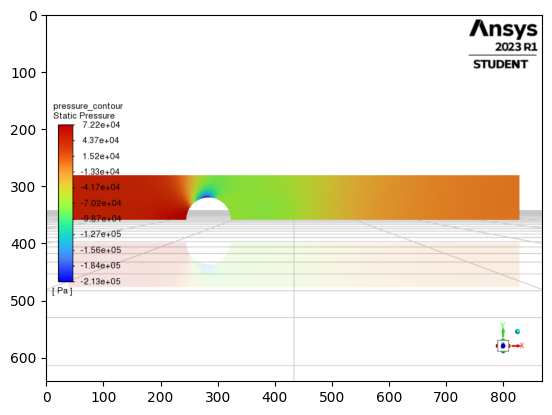

In [107]:
plt.imshow(image.imread("pressure.png"))

In [108]:
solver.results.graphics.contour.create("turbulence-energy_contour")
solver.results.graphics.contour["turbulence-energy_contour"](field = "turb-kinetic-energy", surfaces_list = ["symmetry_left"])
solver.results.graphics.contour["turbulence-energy_contour"].display()
solver.results.graphics.views.auto_scale()
solver.results.graphics.picture.save_picture(file_name = "turbulence-kinetic-energy")

'*cx-overwrite-prompt?*'

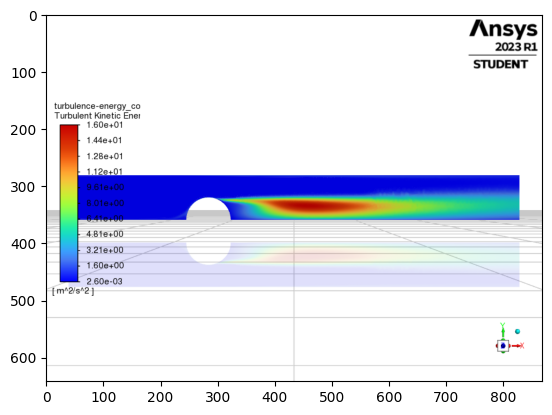

In [109]:
plt.imshow(image.imread("turbulence-kinetic-energy.png"))

Creating the plot for pressure and wall-shear on top and bottom wall

In [110]:
solver.results.plot.xy_plot.create("wall-shear-stress")
solver.results.plot.xy_plot["wall-shear-stress"](y_axis_function = "wall-shear", surfaces_list = ["wall_lower","wall_upper"])
solver.results.plot.xy_plot["wall-shear-stress"].display()

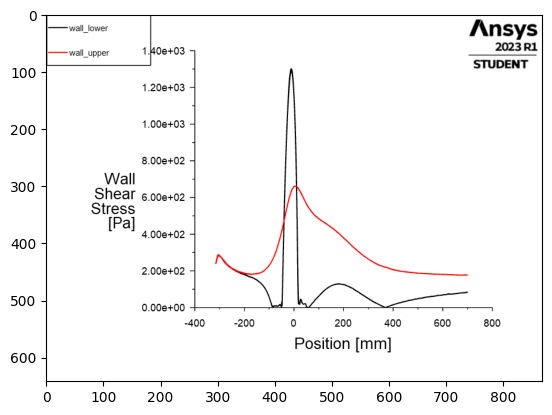

In [111]:
solver.results.graphics.picture.save_picture(file_name = "wall-shear stress")
plt.imshow(image.imread("wall-shear stress.png"))

In [112]:
solver.results.plot.xy_plot.create("Pressure-plot")
solver.results.plot.xy_plot["Pressure-plot"](y_axis_function = "pressure", surfaces_list = ["wall_lower","wall_upper"])
solver.results.plot.xy_plot["Pressure-plot"].display()

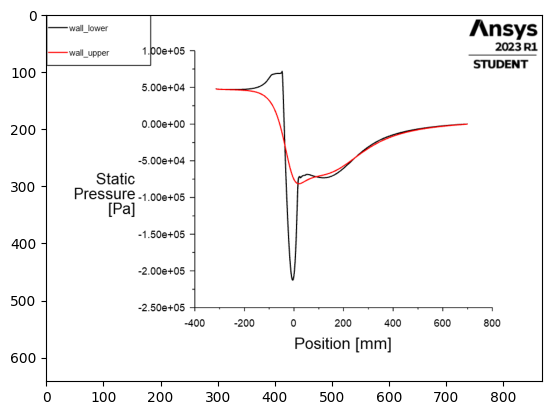

In [113]:
solver.results.graphics.picture.save_picture(file_name = "Pressure plot")
plt.imshow(image.imread("Pressure plot.png"))